In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
from tensorflow import keras

with open('mfcc_data.npy', 'rb') as f:
    mfcc_data = np.load(f)
print(f'MFCC data shape: {mfcc_data.shape}')

label_path = 'deam-dataset/DEAM_Annotations/annotations/annotations averaged per song/song_level/';
labels_1_2000 = pd.read_csv(os.path.join(label_path, 'static_annotations_averaged_songs_1_2000.csv'))
labels_2000_2058 = pd.read_csv(os.path.join(label_path,'static_annotations_averaged_songs_2000_2058.csv'))
labels = pd.concat([labels_1_2000, labels_2000_2058], ignore_index=True, sort=False)
labels = labels[labels_1_2000.columns]
labels.columns = labels.columns.str.replace(' ', '')

valence = labels['valence_mean'].to_numpy()
arousal = labels['arousal_mean'].to_numpy()
y = np.vstack([valence, arousal]).T
print(f'Labels shape: {y.shape}')

MFCC data shape: (1802, 1920, 20)
Labels shape: (1802, 2)


In [2]:
from tqdm import tqdm
import csv

sample_labels_path = 'deam-dataset/DEAM_Annotations/annotations/annotations averaged per song/dynamic'
sample_valence = pd.read_csv(os.path.join(sample_labels_path, 'valence.csv')).T
sample_arousal = pd.read_csv(os.path.join(sample_labels_path, 'arousal.csv')).T

def categorise_sample_labels(v, a, bound):
  if v > bound and a > bound:
    return 0
  elif v > bound and a < bound:
    return 1
  elif v < bound and a > bound:
    return 2
  elif v < bound and a < bound:
    return 3
  else:
    return 4

# returns opensmile feature data and categorised labels (per sample basis)
# in a dictionary format, where keys are the names (2, 3, ...) of the audio files in the dataset
def get_data_and_labels_for_each_sample_in_song(valence, arousal):
  all_labels = {}
  all_data = {}
  dir = 'features/'

  for i in range(len(valence.columns)):
    labels = []
    data = []

    filename = str(int(valence[i]['song_id']))+'.csv'
    f = open(dir+filename, 'r')
    reader = list(csv.reader(f, delimiter=';'))

    if len(reader) < 91:
      pad = [reader[len(reader)-1]]*(91-len(reader))
      reader = reader+pad
    
    for num in range(15000, 45001, 500):
      v = valence[i]['sample_'+str(num)+'ms']
      a = arousal[i]['sample_'+str(num)+'ms']

      category = categorise_sample_labels(v,a,0.1)
      # removes sample of category 4 from reader
      if category != 4:
        labels.append(category)
        data.append(reader[num//500])

    #cutting or padding if len(labels) != 60
    if len(labels) > 60:
       labels = labels[:60]
       data = data[:60]
    elif len(labels) < 60:
      #most_common_no = max(set(labels), key = labels.count)
      labels += [labels[-1]]*(60-len(labels))
      data += [data[-1]]*(60-len(data))

    if len(labels) != len(data):
      print(len(labels), len(data))
    
    all_labels[int(valence[i]['song_id'])] = keras.utils.to_categorical(labels, num_classes=4)
    all_data[int(valence[i]['song_id'])] = data

  return all_labels, all_data
sample_labels, deam_features_data = get_data_and_labels_for_each_sample_in_song(sample_valence, sample_arousal)

In [3]:
# builds a numpy array for opensmile features and sampling labels respectively
def build_X_y(all_data, all_labels):
  X = []
  y = []
  for key in all_data.keys():
    X.append(all_data[key])
    y.append(all_labels[key])

  X = np.array(X, dtype=np.float32, ndmin=3)
  y = np.array(y, dtype=np.int32)

  print('X.shape:', X.shape) 
  print('y.shape:', y.shape)

  return X, y

deam_features, sample_y = build_X_y(deam_features_data, sample_labels)

X.shape: (1802, 60, 261)
y.shape: (1802, 60, 4)


In [4]:
import librosa

# input: 3D matrix representation of data(data_length, frames, coeffs), time-step size (in seconds)
# output: 4D matrix representation of split into time-steps (data_length, n_time_steps, frames per timestep, coeffs)
def split_timesteps(data, time_step=0.5):
    n_frames = data.shape[1]
    time_step_size = librosa.time_to_frames(time_step, sr=22050, hop_length=512)
    n_time_steps = math.floor(n_frames / time_step_size)
    
    print(f'Total no. of frames per data point: {n_frames}')
    print(f'No. of time steps: {n_time_steps}')
    print(f'No. of frames per time step: {time_step_size}')
    
    new_data = np.empty([data.shape[0], n_time_steps, time_step_size, data.shape[2]])
    
    frame_idxes = np.arange(0, n_frames, time_step_size)[:n_time_steps]
    for data_i in range(data.shape[0]):
        data_pt = np.empty([n_time_steps, time_step_size, data.shape[2]])
        for i, frame_idx in enumerate(frame_idxes):
            start_frame = frame_idx
            end_frame = frame_idx + time_step_size
            if end_frame > n_frames: 
                break
            data_pt[i] = data[data_i][start_frame:end_frame, :]
        new_data[data_i] = data_pt
    return new_data

split_mfcc = split_timesteps(mfcc_data, time_step=0.5)
split_mfcc.shape

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


Total no. of frames per data point: 1920
No. of time steps: 91
No. of frames per time step: 21


(1802, 91, 21, 20)

In [5]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=20)

temp_y = []
idx = np.arange(deam_features.shape[0])
for i in range(1802):
    not_one_hot = sample_y[i].argmax(axis=1).tolist()
    most_common_no = max(set(not_one_hot), key = not_one_hot.count)
    temp_y.append(most_common_no)
temp_y = np.array(temp_y)


for train_index, test_index in sss.split(idx, temp_y):
    X_idx_trn, X_idx_test = idx[train_index], idx[test_index]
    sample_y_trn, sample_y_test = sample_y[train_index], sample_y[test_index]
    single_y_trn, single_y_test = y[train_index], y[test_index]

trn_temp_y = temp_y[X_idx_trn]
for train_index, valid_index in sss.split(X_idx_trn, trn_temp_y):
    X_idx_train, X_idx_valid = X_idx_trn[train_index], X_idx_trn[valid_index]
    sample_y_train, sample_y_valid = sample_y_trn[train_index], sample_y_trn[valid_index]  
    single_y_train, single_y_valid = single_y_trn[train_index], single_y_trn[valid_index]  
    
deam_train, deam_valid, deam_test = deam_features[X_idx_train], deam_features[X_idx_valid], deam_features[X_idx_test]
mfcc_train, mfcc_valid, mfcc_test = split_mfcc[X_idx_train], split_mfcc[X_idx_valid], split_mfcc[X_idx_test]
mfcc_train, mfcc_valid, mfcc_test = mfcc_train[:, -60:, :], mfcc_valid[:, -60:, :], mfcc_test[:, -60:, :]

In [6]:
deam_train.shape

(1152, 60, 261)

In [7]:
mfcc_train.shape

(1152, 60, 21, 20)

In [16]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

def performance_review(model, x_test, y_test, y_pred):
    print('Test accuracy: ', accuracy_score(y_test, y_pred))
    
    print('Classification Report: \n', classification_report(y_test, y_pred))
    
    pd_y_test = pd.Series(y_test, name='Actual')
    pd_y_pred = pd.Series(y_pred, name='Predicted')
    df_confusion = pd.crosstab(pd_y_test, pd_y_pred)
    print('Confusion matrix: \n')
    
    sns.heatmap(df_confusion, annot=True, fmt='g')
    plt.show()

#     print('Area under Receiver Operating Characteristic curve (ROC-AUC score)', 
#           roc_auc_score(y_test_encoded, y_pred_encoded, multi_class='ovo'))
    

In [9]:
from functools import partial
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, 
                                     TimeDistributed, LSTM,
                                     Flatten, Dense, Dropout, concatenate,
                                     RepeatVector, LeakyReLU,
                                     LayerNormalization, BatchNormalization)

leaky_relu = LeakyReLU(alpha=0.05)
conv_layer = partial(Conv1D, kernel_size=4, activation=leaky_relu, padding='SAME', strides=1)
pooling = partial(MaxPooling1D, pool_size=3, strides=3, padding='SAME')

cnn_input_shape = (mfcc_train.shape[1], mfcc_train.shape[2], mfcc_train.shape[3])
mfcc_input =  keras.Input(shape=cnn_input_shape, name='mfcc')
x = TimeDistributed(LayerNormalization())(mfcc_input)
x = TimeDistributed(conv_layer(input_shape=cnn_input_shape, filters=32, kernel_size=6))(x)
x = TimeDistributed(pooling())(x)
x = TimeDistributed(conv_layer(filters=64))(x)
x = TimeDistributed(pooling())(x)
x = TimeDistributed(conv_layer(filters=64))(x)
x = TimeDistributed(pooling())(x)
x = TimeDistributed(Flatten())(x)
mfcc_output = Dense(256, activation=leaky_relu)(x)

opensmile_input_shape = (deam_train.shape[1], deam_train.shape[2])
opensmile_input = keras.Input(shape=opensmile_input_shape, name='opensmile')
combined_x = concatenate([mfcc_output, opensmile_input])
x = LSTM(128, input_shape=(combined_x.shape[1], combined_x.shape[2]), return_sequences=True)(combined_x)
x = LSTM(128, return_sequences=True)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
mood_pred = keras.layers.Dense(4, activation='softmax')(x)

cat_model = keras.Model(inputs=[mfcc_input, opensmile_input], outputs=mood_pred)

optimizer = keras.optimizers.Nadam(lr=0.00005)

cat_model.compile(optimizer=optimizer, 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

cat_model.fit({'mfcc': mfcc_train, 'opensmile': deam_train}, 
          sample_y_train,
          validation_data=({'mfcc': mfcc_valid, 'opensmile': deam_valid}, sample_y_valid),
          batch_size=32, 
          epochs=50)

Epoch 1/50
36/36 [==============================] - 2s 52ms/step - loss: 1.3392 - accuracy: 0.3561 - val_loss: 1.2842 - val_accuracy: 0.4461
Epoch 2/50
36/36 [==============================] - 1s 28ms/step - loss: 1.2736 - accuracy: 0.4380 - val_loss: 1.2413 - val_accuracy: 0.4689
Epoch 3/50
36/36 [==============================] - 1s 28ms/step - loss: 1.2454 - accuracy: 0.4616 - val_loss: 1.2225 - val_accuracy: 0.4757
Epoch 4/50
36/36 [==============================] - 1s 27ms/step - loss: 1.2302 - accuracy: 0.4760 - val_loss: 1.2086 - val_accuracy: 0.4918
Epoch 5/50
36/36 [==============================] - 1s 27ms/step - loss: 1.2158 - accuracy: 0.4886 - val_loss: 1.1981 - val_accuracy: 0.5015
Epoch 6/50
36/36 [==============================] - 1s 28ms/step - loss: 1.2020 - accuracy: 0.4992 - val_loss: 1.1887 - val_accuracy: 0.5112
Epoch 7/50
36/36 [==============================] - 1s 28ms/step - loss: 1.1923 - accuracy: 0.5122 - val_loss: 1.1802 - val_accuracy: 0.5088
Epoch 8/50
36

12/12 - 0s - loss: 1.0925 - accuracy: 0.5747
(361, 60, 4)
Test accuracy:  0.5746999076638966
Classification Report: 
               precision    recall  f1-score   support

           0       0.56      0.87      0.68      8629
           1       0.35      0.03      0.05      2527
           2       0.60      0.02      0.04      3391
           3       0.61      0.68      0.64      7113

    accuracy                           0.57     21660
   macro avg       0.53      0.40      0.35     21660
weighted avg       0.56      0.57      0.49     21660

Confusion matrix: 



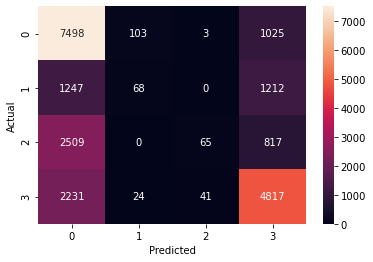

ROC-AUC score:  0.7079887125923804


In [17]:
test_loss, test_acc = cat_model.evaluate({'mfcc': mfcc_test, 'opensmile': deam_test}, sample_y_test, verbose=2)
# print('\nTest accuracy:', test_acc)

y_pred = cat_model.predict({'mfcc': mfcc_test, 'opensmile': deam_test})
sample_y_test_reshape = np.argmax(sample_y_test, axis=2)
sample_y_test_reshape = sample_y_test_reshape.flatten();
y_pred_reshape = np.argmax(y_pred, axis=2)
y_pred_reshape = y_pred_reshape.flatten()
print(y_pred.shape)

performance_review(cat_model, {'mfcc': mfcc_test, 'opensmile': deam_test}, sample_y_test_reshape, y_pred_reshape)

encoded_y_pred = y_pred.reshape(y_pred.shape[0] * y_pred.shape[1], y_pred.shape[2])
print('ROC-AUC score: ', roc_auc_score(sample_y_test_reshape, encoded_y_pred, multi_class='ovr'))

### Regression w/ original valence + arousal values per song

In [11]:
pooling = partial(MaxPooling1D, pool_size=4, strides=4, padding='SAME')

cnn_input_shape = (mfcc_train.shape[1], mfcc_train.shape[2], mfcc_train.shape[3])
mfcc_input =  keras.Input(shape=cnn_input_shape, name='mfcc')
x = TimeDistributed(LayerNormalization())(mfcc_input)
x = TimeDistributed(conv_layer(input_shape=cnn_input_shape, filters=32, kernel_size=8))(x)
x = TimeDistributed(pooling())(x)
x = TimeDistributed(conv_layer(filters=64))(x)
x = TimeDistributed(pooling())(x)
x = TimeDistributed(conv_layer(filters=64))(x)
x = TimeDistributed(pooling())(x)
x = TimeDistributed(Flatten())(x)
mfcc_output = Dense(256, activation=leaky_relu)(x)

opensmile_input_shape = (deam_train.shape[1], deam_train.shape[2])
opensmile_input = keras.Input(shape=opensmile_input_shape, name='opensmile')
combined_x = concatenate([mfcc_output, opensmile_input])
x = LSTM(128, return_sequences=True, input_shape=(combined_x.shape[1],combined_x.shape[2]))(combined_x)
x = LSTM(128)(x)
x = keras.layers.Dense(256, activation=leaky_relu)(x)
x = keras.layers.Dropout(0.5)(x)
mood_pred = keras.layers.Dense(2)(x)

optimizer = keras.optimizers.Nadam(lr=0.00008)


reg_model = keras.Model(inputs=[mfcc_input, opensmile_input], outputs=mood_pred)
reg_model.compile(loss='mae', optimizer=optimizer, metrics=['mean_squared_error'])

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=20)

reg_model.fit({'mfcc': mfcc_train, 'opensmile': deam_train}, 
          single_y_train,
          validation_data=({'mfcc': mfcc_valid, 'opensmile': deam_valid}, single_y_valid),
          batch_size=32, 
          epochs=100,
          callbacks=early_stopping)

Epoch 1/100
36/36 [==============================] - 2s 45ms/step - loss: 4.2832 - mean_squared_error: 20.0439 - val_loss: 3.5048 - val_mean_squared_error: 13.7330
Epoch 2/100
36/36 [==============================] - 1s 26ms/step - loss: 2.0192 - mean_squared_error: 5.8667 - val_loss: 0.9960 - val_mean_squared_error: 1.4447
Epoch 3/100
36/36 [==============================] - 1s 27ms/step - loss: 1.1780 - mean_squared_error: 2.0833 - val_loss: 0.9917 - val_mean_squared_error: 1.4393
Epoch 4/100
36/36 [==============================] - 1s 26ms/step - loss: 1.1933 - mean_squared_error: 2.1501 - val_loss: 0.9846 - val_mean_squared_error: 1.4238
Epoch 5/100
36/36 [==============================] - 1s 26ms/step - loss: 1.1573 - mean_squared_error: 2.0189 - val_loss: 0.9709 - val_mean_squared_error: 1.3824
Epoch 6/100
36/36 [==============================] - 1s 27ms/step - loss: 1.1422 - mean_squared_error: 1.9632 - val_loss: 0.9672 - val_mean_squared_error: 1.3699
Epoch 7/100
36/36 [=======

12/12 [==============================] - 0s 7ms/step - loss: 0.8134 - mean_squared_error: 1.0759
Test reg RMSE: [0.9019079435786036, 1.0372697092033187]
Test accuracy:  0.6011080332409973
Classification Report: 
               precision    recall  f1-score   support

          AN       0.00      0.00      0.00        42
          AP       0.63      0.72      0.67       142
          PN       0.61      0.85      0.71       132
          PP       0.23      0.07      0.10        45

    accuracy                           0.60       361
   macro avg       0.37      0.41      0.37       361
weighted avg       0.50      0.60      0.54       361

Confusion matrix: 



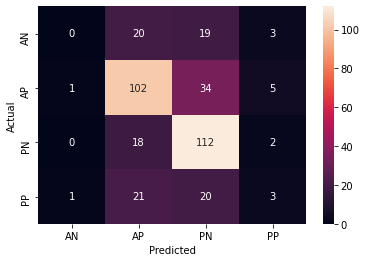

In [18]:
from sklearn.metrics import accuracy_score

def categorize_val_arousal(data):
    cat_data = []
    # A: active, P: passive
    # P: positive, N: negative
    for point in data:
        valence, arousal = point[0], point[1]
        if valence >= 5 and arousal >= 5:
            cat_data.append('AP')
        elif valence < 5 and arousal >= 5:
            cat_data.append('AN')
        elif valence >= 5 and arousal < 5:
            cat_data.append('PP')
        elif valence < 5 and arousal < 5:
            cat_data.append('PN')
    return np.array(cat_data, dtype='str')


score = reg_model.evaluate({'mfcc': mfcc_test, 'opensmile': deam_test}, single_y_test)
print(f'Test reg RMSE: {list(map(math.sqrt, score))}')
y_pred = reg_model.predict({'mfcc': mfcc_test, 'opensmile': deam_test})

cat_y_pred = categorize_val_arousal(y_pred)
cat_y_test = categorize_val_arousal(single_y_test)

performance_review(reg_model, {'mfcc': mfcc_test, 'opensmile': deam_test}, cat_y_test, cat_y_pred)

In [14]:
leaky_relu = LeakyReLU(alpha=0.05)
conv_layer = partial(Conv1D, kernel_size=4, activation=leaky_relu, padding='SAME', strides=1)
pooling = partial(MaxPooling1D, pool_size=2, strides=2, padding='SAME')

cnn_input_shape = (mfcc_train.shape[1], mfcc_train.shape[2], mfcc_train.shape[3])
mfcc_input =  keras.Input(shape=cnn_input_shape, name='mfcc')
x = TimeDistributed(LayerNormalization())(mfcc_input)
x = TimeDistributed(conv_layer(input_shape=cnn_input_shape, filters=32, kernel_size=8))(x)
x = TimeDistributed(pooling())(x)
x = TimeDistributed(conv_layer(filters=64))(x)
x = TimeDistributed(pooling())(x)
x = TimeDistributed(conv_layer(filters=64))(x)
x = TimeDistributed(pooling())(x)
x = TimeDistributed(Flatten())(x)
mfcc_output = Dense(256, activation=leaky_relu)(x)

opensmile_input_shape = (deam_train.shape[1], deam_train.shape[2])
opensmile_input = keras.Input(shape=opensmile_input_shape, name='opensmile')
combined_x = concatenate([mfcc_output, opensmile_input])
x = LSTM(128, return_sequences=True, input_shape=(combined_x.shape[1],combined_x.shape[2]))(combined_x)
x = LSTM(128)(x)
x = keras.layers.Dense(256, activation=leaky_relu)(x)
x = keras.layers.Dropout(0.5)(x)
mood_pred = keras.layers.Dense(2)(x)

optimizer = keras.optimizers.Nadam(lr=0.0001)

best_model = keras.Model(inputs=[mfcc_input, opensmile_input], outputs=mood_pred)
best_model.compile(loss='mae', optimizer=optimizer, metrics=['mean_squared_error'])

mfcc_data = np.concatenate((mfcc_train, mfcc_valid, mfcc_test), axis=0)
opensmile_data = np.concatenate((deam_train, deam_valid, deam_test), axis=0)
labels = np.concatenate((single_y_train, single_y_valid, single_y_test), axis=0)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=20)
best_model.fit({'mfcc': mfcc_data, 'opensmile': opensmile_data}, 
          labels,
          batch_size=32, 
          epochs=100,
          callbacks=early_stopping)

Epoch 1/100
57/57 [==============================] - 1s 19ms/step - loss: 3.5488 - mean_squared_error: 15.7089
Epoch 2/100
57/57 [==============================] - 1s 18ms/step - loss: 1.1797 - mean_squared_error: 2.0941
Epoch 3/100
57/57 [==============================] - 1s 18ms/step - loss: 1.1674 - mean_squared_error: 2.0539
Epoch 4/100
57/57 [==============================] - 1s 18ms/step - loss: 1.1190 - mean_squared_error: 1.8838
Epoch 5/100
57/57 [==============================] - 1s 18ms/step - loss: 1.0962 - mean_squared_error: 1.8111
Epoch 6/100
57/57 [==============================] - 1s 18ms/step - loss: 1.0985 - mean_squared_error: 1.8423
Epoch 7/100
57/57 [==============================] - 1s 17ms/step - loss: 1.0732 - mean_squared_error: 1.7694
Epoch 8/100
57/57 [==============================] - 1s 18ms/step - loss: 1.0619 - mean_squared_error: 1.7575
Epoch 9/100
57/57 [==============================] - 1s 18ms/step - loss: 1.0613 - mean_squared_error: 1.7383
Epoch 10/

Test accuracy:  0.6011080332409973
Classification Report: 
               precision    recall  f1-score   support

          AN       0.00      0.00      0.00        42
          AP       0.63      0.72      0.67       142
          PN       0.61      0.85      0.71       132
          PP       0.23      0.07      0.10        45

    accuracy                           0.60       361
   macro avg       0.37      0.41      0.37       361
weighted avg       0.50      0.60      0.54       361

Confusion matrix: 



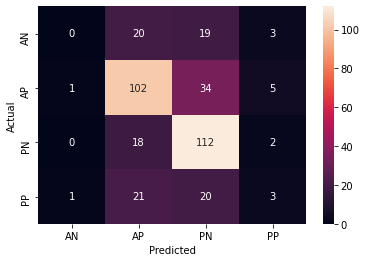

INFO:tensorflow:Assets written to: reg_model/assets


In [19]:
performance_review(best_model, {'mfcc': mfcc_test, 'opensmile': deam_test}, cat_y_test, cat_y_pred)

# save the model
best_model.save('reg_model')